<a href="https://colab.research.google.com/github/krnwnaji/Google-Earth-Engine/blob/main/monthly_rainfall_chirps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import ee

In [9]:
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-krnwnaji1995')

In [19]:

year_end = datetime.strptime(end_date, '%Y-%m-%d').year + 1
year_end

2026

In [20]:
aoi = ee.Geometry.Polygon(
        [[[101.96099306841231, 0.7953663117309334],
          [101.96099306841231, -0.1274595994593136],
          [103.18596865434981, -0.1274595994593136],
          [103.18596865434981, 0.7953663117309334]]], None, False);

# Alternatively, you can load your area from shapefile
# gdf = gpd.read_file('your_shapefile.shp')
# aoi = ee.Geometry.Polygon(gdf.iloc[0].geometry.exterior.coords)

# Set the time range
start_date = '2019-01-01'
end_date = '2025-04-01'

# Convert the string to a datetime object
year_start = datetime.strptime(start_date, '%Y-%m-%d').year
year_end = datetime.strptime(end_date, '%Y-%m-%d').year + 1

# Load CHIRPS dataset
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date)


# Function to calculate monthly total rainfall
def monthly_rainfall(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    monthly = chirps.filterDate(start, end)

    # Only proceed if there are images in that month
    size = monthly.size().getInfo()
    if size == 0:
        print(f"Skipping {year}-{month:02d}: No data available.")
        return None
    else:
        monthly_sum = monthly.sum().set({
            'year': year,
            'month': month
        })
        return monthly_sum

# Create a list of all months in the range
years = list(range(year_start, year_end))  # including 2025
months = list(range(1, 13))

monthly_images = []
for year in years:
    for month in months:
        img = monthly_rainfall(year, month)
        if img is not None:
            monthly_images.append(img)

# Convert to ImageCollection
if not monthly_images:
    raise Exception("No monthly images available for the selected period and area.")


# Convert to ImageCollection
monthly_collection = ee.ImageCollection(monthly_images)


Skipping 2025-03: No data available.
Skipping 2025-04: No data available.
Skipping 2025-05: No data available.
Skipping 2025-06: No data available.
Skipping 2025-07: No data available.
Skipping 2025-08: No data available.
Skipping 2025-09: No data available.
Skipping 2025-10: No data available.
Skipping 2025-11: No data available.
Skipping 2025-12: No data available.


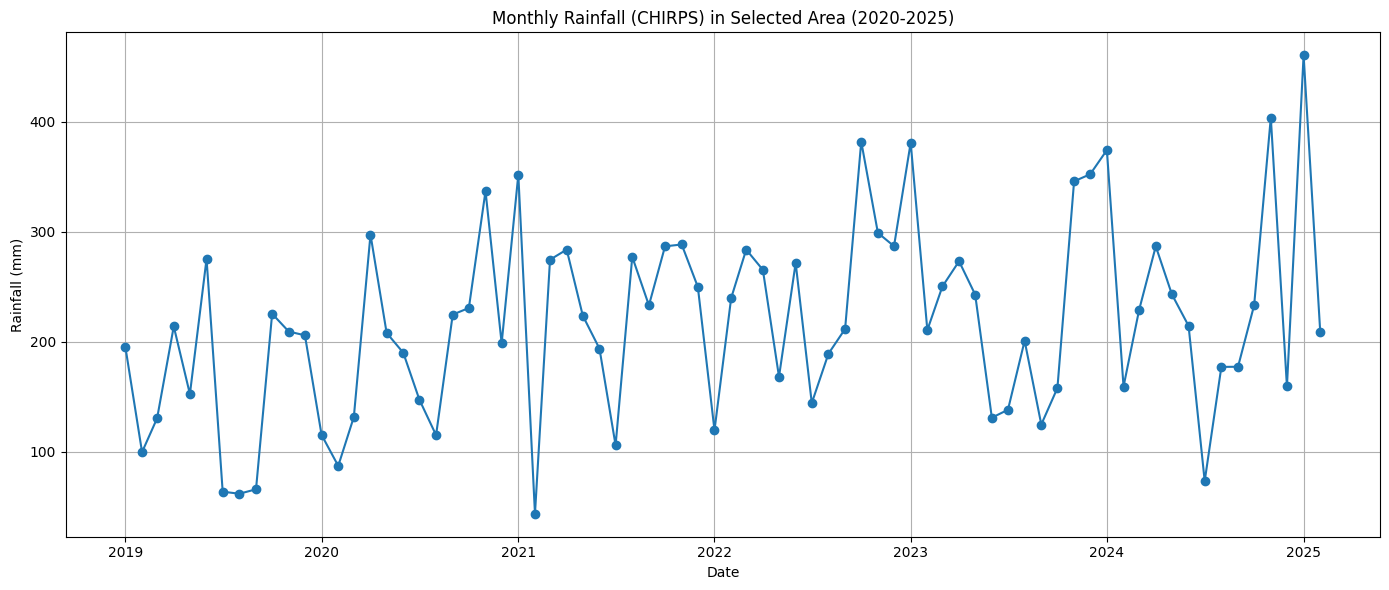

Data saved to 'monthly_rainfall_chirps.csv'


In [21]:

# Reduce over the AOI (mean rainfall)
def extract_mean(image):
    stat = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=5000,
        bestEffort=True
    )
    return ee.Feature(None, {
        'year': image.get('year'),
        'month': image.get('month'),
        'rainfall': stat.get('precipitation')
    })

features = monthly_collection.map(extract_mean).getInfo()

# Convert Earth Engine output to Pandas DataFrame
data = []
for f in features['features']:
    props = f['properties']
    data.append(props)

df = pd.DataFrame(data)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['rainfall'] = pd.to_numeric(df['rainfall'], errors='coerce')

# Sort by date
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('date')

# Plot the data
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['rainfall'], marker='o', linestyle='-')
plt.title('Monthly Rainfall (CHIRPS) in Selected Area (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the result
df.to_csv('monthly_rainfall_chirps.csv', index=False)
print("Data saved to 'monthly_rainfall_chirps.csv'")
